# model

Please refer to README file for project overview.

In [1]:
nb_epoch = 5


data_dir = "../../../DATA/behavioral_cloning_data/"
processed_images_dir = "processed_images_64/"
image_final_width = 64
model_dir = "../../../DATA/MODELS/"
model_name = "model_p3_keras_tf_mini_14x64x3_"
batch_size = 256
driving_data_csv = "driving_log_no_zeros.csv"

In [2]:
import matplotlib.image as mpimg
from scipy import misc
import matplotlib.pyplot as plt
import cv2

In [3]:
import DataHelper
#print(DataHelper.__doc__)
from DataHelper import test_read_csv, read_csv
#print(read_csv.__doc__)
#test_read_csv()
# fetch actual log of driving data
headers, data = read_csv(data_dir + driving_data_csv)

Using TensorFlow backend.


imported rows 3679


# Split data into training, testing and validation sets

In [4]:
from DataHelper import split_random

# keras actually does it's own split, so here I just reserve small validation set.
training, testing, validation = split_random(data, percent_train=85, percent_test=15) 

print("training",training.shape)
print("testing",testing.shape)
print("validation",validation.shape)

percent_validation 0
training (3127, 7)
testing (551, 7)
validation (0, 7)


# Create Labels: steering value classes

- Please review notebook "preprocessing", section: "Steering value distribution".
- Training labels have values ranging from -1 to +1.
- When you steer with **keyboard** the STEPS are rather corse, so I think I can get away with **discrete steering angles, i.e. classes**.
- I will start training with 21 equally spread classes, if needed I will increase to 41.
- I want to make sure that my classes include **0.0 (zero)** as it is most common value.

min_value -0.942695
max_value 1.0
spread 1.9427
recommended number of classes 195


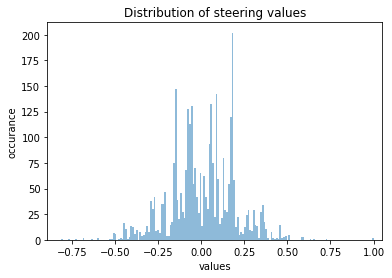

In [5]:
from DataHelper import plot_histogram, get_steering_values, find_nearest

steering_angles = get_steering_values(training)

change_step=0.01 # test data changes
plot_histogram("steering values", steering_angles, change_step)

# Round steering angles

- I might consider rounding the steering angles to lower amount of training
- I assume the classification labels to be float values

steering_classes [-1.   -0.95 -0.9  -0.85 -0.8  -0.75 -0.7  -0.65 -0.6  -0.55 -0.5  -0.45
 -0.4  -0.35 -0.3  -0.25 -0.2  -0.15 -0.1  -0.05  0.    0.05  0.1   0.15
  0.2   0.25  0.3   0.35  0.4   0.45  0.5   0.55  0.6   0.65  0.7   0.75
  0.8   0.85  0.9   0.95  1.  ]
Number of classes 41


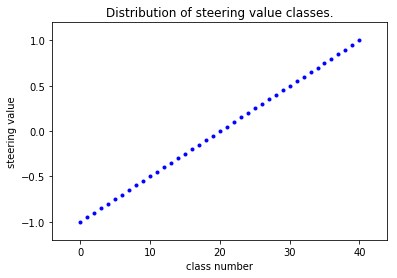

In [6]:
import numpy as np
from numpy import ndarray

# desired number of classes, could be 21, too.
from DataHelper import create_steering_classes
steering_classes = create_steering_classes(number_of_classes = 41)

print("steering_classes", steering_classes)
number_of_classes = steering_classes.shape[0]
print("Number of classes", number_of_classes)

import matplotlib.pyplot as plt
plt.plot(steering_classes, 'b.')
plt.margins(0.1)
plt.title("Distribution of steering value classes.")
plt.xlabel("class number")
plt.ylabel('steering value')
plt.show()

In [7]:


training_labels = np.array([], dtype=np.float32)

for raw_label in steering_angles:
    rounded_value = float( find_nearest(steering_classes, raw_label) )
    training_labels = np.append(training_labels, [rounded_value])
        
print(training_labels[0:50])

[ 0.   -0.15 -0.05  0.15 -0.05  0.2  -0.05 -0.1   0.1  -0.15 -0.1   0.05
  0.    0.15  0.    0.1  -0.05  0.1  -0.95  0.    0.   -0.05  0.25  0.05
 -0.25 -0.05 -0.05  0.   -0.5  -0.1  -0.45 -0.35  0.15 -0.05  0.15  0.35
 -0.05 -0.35 -0.3   0.15  0.4   0.25  0.1   0.15  0.2  -0.2   0.1   0.1
 -0.15 -0.1 ]


min_value -0.95
max_value 1.0
spread 1.95
recommended number of classes 195


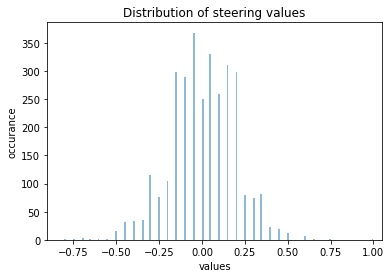

In [8]:
change_step=0.01 # test data changes
plot_histogram("steering values", training_labels, change_step)

# Encoding Training Labels in one-hot notation

In [9]:
from DataHelper import encode_one_hot, locate_one_hot_position

y_one_hot =  encode_one_hot(defined_classes=steering_classes, sample_labels=training_labels)

print("y_one_hot", y_one_hot.shape)

defined_classes
 [-1.  -1.  -0.9 -0.8 -0.8 -0.8 -0.7 -0.6 -0.6 -0.6 -0.5 -0.4 -0.4 -0.4 -0.3
 -0.2 -0.2 -0.1 -0.1 -0.   0.   0.1  0.1  0.2  0.2  0.2  0.3  0.4  0.4  0.5
  0.5  0.6  0.6  0.7  0.7  0.8  0.8  0.8  0.9  1.   1. ]
class_count: 41
sample_count: 3127
one_hot examples 
 [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0]]
one_hot shape (3127, 41)
y_one_hot (3127, 41)


## One-hot print and verify

In [10]:
for index in range(10):
    print( index, ") \t", training_labels[index], "\t", y_one_hot[index],  
          "@", locate_one_hot_position(steering_classes, training_labels[index] ) )

0 ) 	 0.0 	 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0] @ 20
1 ) 	 -0.15 	 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0] @ 17
2 ) 	 -0.05 	 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0] @ 19
3 ) 	 0.15 	 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0] @ 23
4 ) 	 -0.05 	 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0] @ 19
5 ) 	 0.2 	 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0] @ 24
6 ) 	 -0.05 	 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0] @ 19
7 ) 	 -0.1 	 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0] @ 18
8 ) 	 0.1 	 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0] @ 22
9 ) 	 -0.15 	 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0

# Extract training features (images)

In [11]:
from DataHelper import get_image_center_values 
image_names = get_image_center_values(training)
print(image_names.shape)
print(image_names[1])

(3127,)
IMG/center_2016_12_01_13_46_26_346.jpg


## Create a list of image paths pointing to 64px version

In [12]:
image_paths = []
for image_name in image_names:
    image_paths.extend([data_dir + processed_images_dir + image_name])
print(image_paths[1]) 

../../../DATA/behavioral_cloning_data/processed_images_64/IMG/center_2016_12_01_13_46_26_346.jpg


training_images matrix shape (3127, 14, 64, 3)


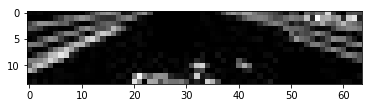

In [13]:
from DataHelper import read_image
training_images = np.array([ read_image(path) for path in image_paths] )

print ("training_images matrix shape", training_images.shape)

plt.imshow(training_images[2], cmap='gray')
plt.show()

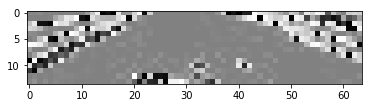

sample_image 
 (14, 64, 3) 
 [[[-0.47254902]
  [-0.48039216]
  [-0.46470588]
  [-0.49607843]
  [-0.48823529]
  [-0.48823529]
  [-0.5       ]
  [-0.49215686]
  [-0.48823529]
  [-0.5       ]
  [-0.49215686]
  [-0.39803922]
  [-0.23333333]
  [-0.06862745]]]


In [14]:
from DataHelper import normalize_grayscale
training_features = normalize_grayscale(training_images) # you end up with -0.48823529 instead of -0.5
sample_image = training_features[2] #X_train[2]

plt.imshow(sample_image, cmap='gray')
plt.show()

show_rows = 1 # of 64
show_cols = 14
show_channels = 1 # of 3

print("sample_image \n", sample_image.shape,"\n", sample_image[:show_rows,:show_cols,:show_channels]) #  

# Keras (with TensorFlow)

https://keras.io/layers/convolutional/

In [15]:
import keras.backend as K
from keras.models import Sequential
from keras.layers import ELU
from keras.layers.core import Flatten, Dense, Dropout, Activation, Lambda

from keras.activations import relu, softmax
from keras.optimizers import SGD
import cv2, numpy as np
from DataHelper import mean_pred, false_rates

from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D, Convolution1D

### See Model_Keras_VGG_16.py

This file (in the same directory) contains MODEL definiteion for VGG.16.

# Adjust VGG.16 model architecture to match my needs

# Build custom sized model

In [16]:
from keras.layers import InputLayer, Input

model = Sequential()

model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu',
                        input_shape=(14, 64 ,3), dim_ordering='tf'))
model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))

#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

model.add(Flatten())


#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(256, activation='relu'))


model.add(Dense(41, activation='linear')) # default: linear | softmax | relu | sigmoid
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 14, 64, 64)    1792        convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 14, 64, 128)   73856       convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_3 (Convolution2D)  (None, 14, 64, 256)   295168      convolution2d_2[0][0]            
____________________________________________________________________________________________________
flatten_1 (Flatten)              (None, 229376)        0           convolution2d_3[0][0]            
___________________________________________________________________________________________

# Compile model (configure learning process)

In [17]:
# Before training a model, you need to configure the learning process, which is done via the compile method.
# 
# keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

optimizer='sgd' # | 'rmsprop'
loss_function="mse" # | 'binary_crossentropy' | 'mse' | mean_squared_error | sparse_categorical_crossentropy
metrics_array=['accuracy'] # , mean_pred, false_rates

model.compile(optimizer, loss_function, metrics_array)

# Replace model with one stored on disk

- If you replace the model, the INPUT dimetions have to be the same as these trained
- Name your models well

In [18]:
from keras.models import load_model
model_path = model_dir + 'model_p3_keras_tf_mini_14x64x1a__epoch_35_val_loss_0.0200312916701.h5'
model = load_model(model_path) 
last_model_epochs = 35
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 14, 64, 64)    1792        convolution2d_input_2[0][0]      
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 14, 64, 128)   73856       convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_3 (Convolution2D)  (None, 14, 64, 256)   295168      convolution2d_2[0][0]            
____________________________________________________________________________________________________
flatten_1 (Flatten)              (None, 229376)        0           convolution2d_3[0][0]            
___________________________________________________________________________________________

# Train (fit) the model agaist given labels

In [19]:
history = model.fit(training_features, y_one_hot, nb_epoch=nb_epoch, 
                    batch_size=batch_size, verbose=1, validation_split=0.2)

Train on 2501 samples, validate on 626 samples
Epoch 1/5
2501/2501 [==============================] - 109s - loss: 0.0207 - acc: 0.3135 - val_loss: 0.0199 - val_acc: 0.3642
Epoch 2/5
2501/2501 [==============================] - 106s - loss: 0.0207 - acc: 0.3083 - val_loss: 0.0199 - val_acc: 0.35

In [20]:
# list all data in history
print(history.history.keys())

training_accuracy = str( history.history['acc'][nb_epoch-1])
print("training_accuracy", training_accuracy)

training_error = str( history.history['loss'][nb_epoch-1])
print("training_error", training_error)

validation_accuracy = str( history.history['val_acc'][nb_epoch-1])
print("validation_accuracy", validation_accuracy)

validation_error = str( history.history['val_loss'][nb_epoch-1])
print("validation_error", validation_error)

dict_keys(['loss', 'acc', 'val_acc', 'val_loss'])
training_accuracy 0.320271890254
training_error 0.0205937800188
validation_accuracy 0.356230029759
validation_error 0.0198594339299


# Save the model

In [21]:
# creates a HDF5 file '___.h5'
model.save(model_dir + model_name + "_epoch_" + str(nb_epoch + last_model_epochs) 
           + "_val_loss_" + str(validation_error) + ".h5") 
#del model  # deletes the existing model
#model = load_model('my_model.h5')

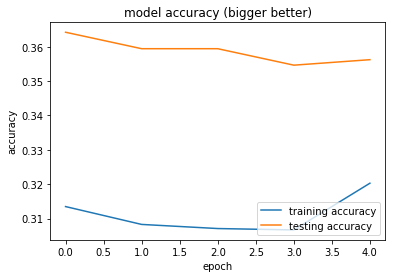

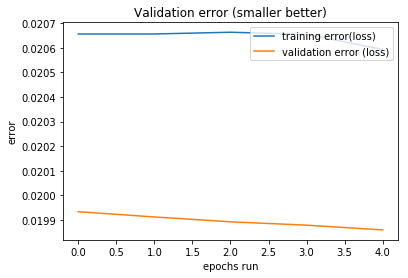

In [22]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy (bigger better)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training accuracy', 'testing accuracy'], loc='lower right')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Validation error (smaller better)')
plt.ylabel('error')
plt.xlabel('epochs run')
plt.legend(['training error(loss)', 'validation error (loss)'], loc='upper right')
plt.show()

# Prediction set

../../../DATA/behavioral_cloning_data/processed_images_64/IMG/center_2016_12_01_13_32_43_659.jpg
(14, 64, 3)


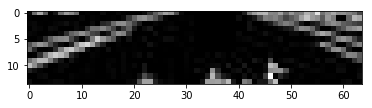

In [23]:
image_name = "IMG/center_2016_12_01_13_32_43_659.jpg" # stering 0.05219137
original_steering_angle = 0.05219137

#image_name = "IMG/center_2016_12_01_13_33_10_579.jpg" # 0.1287396

#image_name = "IMG/center_2016_12_01_13_39_28_024.jpg" # -0.9426954
#original_steering_angle = -0.9426954

image_path =  data_dir + processed_images_dir + image_name
print(image_path)
image = read_image(image_path)
print(image.shape)
plt.imshow(image, cmap='gray')
plt.show()

In [24]:
#expected convolution2d_input_1 to have 4 dimensions, but got array with shape (14, 64, 3)
image = image[None, :, :]

import keras
#from keras.np_utils import probas_to_classes

predictions = model.predict( image, batch_size=1, verbose=1)
print(type(predictions), predictions.shape, predictions)
prediction = float(predictions[0][0])
#print("prediction \n", prediction)
#print("np.argmax(prediction) ",np.argmax(prediction))
most_likely = np.argmax(predictions)
print("np.argmax(predictions) ", most_likely )

1/1 [==============================] - 0s
<class 'numpy.ndarray'> (1, 41) [[-1.52413046 -2.11513925  2.65090084 -2.14097142  1.02204657  0.68669838
  -3.33152175  7.16483688  2.86655259  5.45682049 -0.18482213 -3.19390607
   0.33528778 -2.89572787  3.69142866  0.63688046  0.97883469  9.08335304
   0.91194129  7.59135532 -0.35245833  1.6524601   0.6501776   1.1653055
  -1.11477315  0.40094382  3.54441595 -1.2046243   2.15806031 -2.55069876
  -5.50475788  0.86478621  2.48194265  3.62737489 -2.20519423  0.94645619
  -3.10513473 -1.2961241   2.42907763  1.89108086  8.02173424]]
np.argmax(predictions)  17


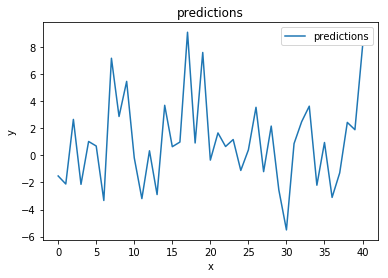

In [25]:
# summarize history for loss
plt.plot(predictions[0])
plt.title('predictions')
plt.ylabel('y')
plt.xlabel('x')
plt.legend(['predictions'], loc='upper right')
plt.show()

In [26]:
print("original steering angle", original_steering_angle)
print("predicted steering angle", steering_classes[most_likely])

original steering angle 0.05219137
predicted steering angle -0.15
